# Movie Recommendation System

## Import packages

In [12]:
import pandas as pd 
import numpy as np 
import random
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS

## Import Movie data set 

In [98]:
data= pd.read_csv('movies.csv')
data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Movie Data set information

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [15]:
movies = data['movieId'].unique().tolist()
len(movies)

9742

## Import Rating Data set 

In [38]:
ratings_data=pd.read_csv('ratingss.csv')
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Rating data set description

In [39]:
ratings_data.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


### Data set preprocessing and cleaning

In [40]:
data.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

In [41]:
ratings_data.isnull().any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

## Import Tags data set

In [43]:
tags_data=pd.read_csv('tags.csv')
tags_data.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [44]:
tags_data.isnull().any()

userId       False
movieId      False
tag          False
timestamp    False
dtype: bool

In [45]:
unique_tags=tags_data['tag'].unique().tolist()
len(unique_tags)

1589

## Merge Movie and Rating data set

In [18]:
movie_data_ratings_data=data.merge(ratings_data,on = 'movieId',how = 'inner')
movie_data_ratings_data.head(3)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946


Merging **Movies** and **Ratings** dataset to map Ratings to appropriate Movie name

### Movie rating Top 25

In [32]:
most_rated = movie_data_ratings_data["title"].value_counts().sort_values(ascending=False)[0:25]

In [34]:
most_rated

Forrest Gump (1994)                                                               329
Shawshank Redemption, The (1994)                                                  317
Pulp Fiction (1994)                                                               307
Silence of the Lambs, The (1991)                                                  279
Matrix, The (1999)                                                                278
Star Wars: Episode IV - A New Hope (1977)                                         251
Jurassic Park (1993)                                                              238
Braveheart (1995)                                                                 237
Terminator 2: Judgment Day (1991)                                                 224
Schindler's List (1993)                                                           220
Fight Club (1999)                                                                 218
Toy Story (1995)                                      

We are displaying the Top 25 Movies with rating count in Decending order

### Split Title into Year and Title

In [35]:
data['year'] =data['title'].str.extract('.*\((.*)\).*',expand = False)
data.head(5)

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


Extracting the year value from the movie name associated with it. We are passing regular expression to fetch the year.

### Reusable function - counts the number of times each genre appear

In [36]:
#define a function that counts the number of times each genre appear:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

### Remove seperator from Genres feature

In [37]:
#here we  make census of the genres:
genre_labels = set()
for s in data['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [38]:
#counting how many times each of genres occur:
keyword_occurences, dum = count_word(data, 'genres', genre_labels)
keyword_occurences

[['Drama', 4361],
 ['Comedy', 3756],
 ['Thriller', 1894],
 ['Action', 1828],
 ['Romance', 1596],
 ['Adventure', 1263],
 ['Crime', 1199],
 ['Sci-Fi', 980],
 ['Horror', 978],
 ['Fantasy', 779],
 ['Children', 664],
 ['Animation', 611],
 ['Mystery', 573],
 ['Documentary', 440],
 ['War', 382],
 ['Musical', 334],
 ['Western', 167],
 ['IMAX', 158],
 ['Film-Noir', 87],
 ['(no genres listed)', 34]]

We are displaying **Movie Genres count occurences**

### Visualize the Keyword Occurances in Wordcloud

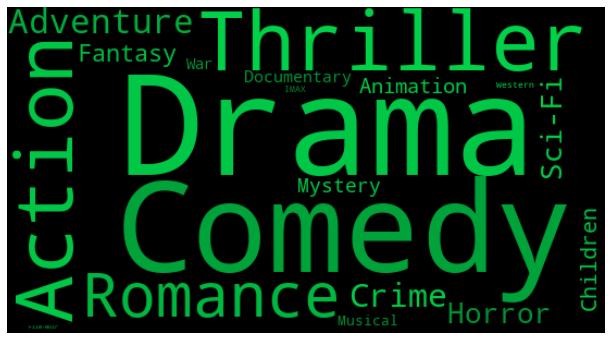

In [41]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


#Finally, the result is shown as a wordcloud:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

The Wordcloud graph highlights, **Drama, Comedy, Thriller, Action and Romance** keywords occurance count is high, followed by Adventure, Crime, Horror, Sci-Fi, Children, Fantasy, Animation, Mystery keywords. Least count goes to Documentary, War, Musical and Western. 

### Visualize Popularity of Genres in Bar Graph

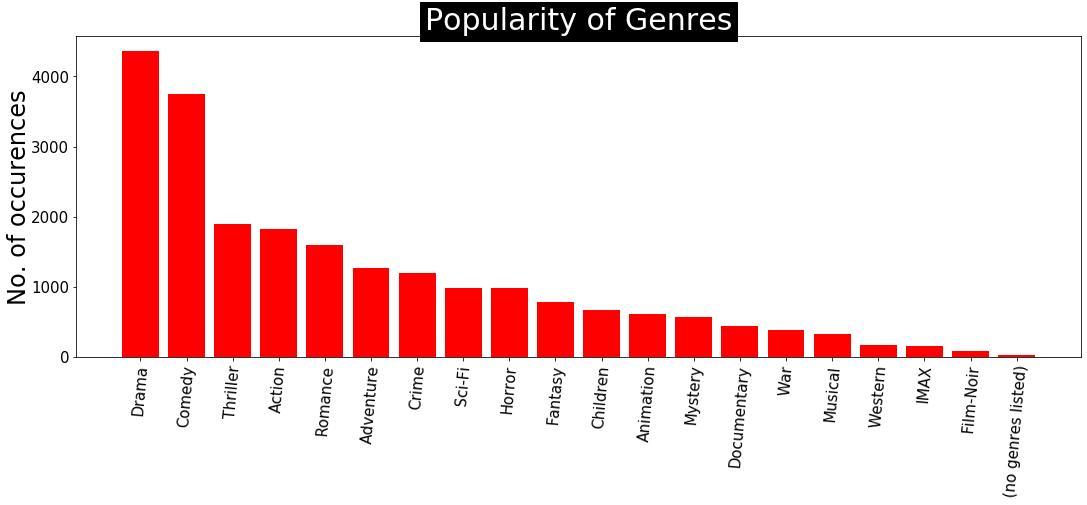

In [42]:
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='r')
plt.title("Popularity of Genres",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

We can inference **Drama, Comedy, Thriller, Action and Romance** are more popular genres.

## Import Movies and Ratings dataset

In [48]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [49]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [50]:
movies.shape

(9742, 3)

In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [51]:
ratings.shape

(100836, 4)

In [52]:
ratings['userId'].value_counts()[0:25]

414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
249    1046
387    1027
182     977
307     975
603     943
298     939
177     904
318     879
232     862
480     836
608     831
600     763
590     728
483     728
105     722
Name: userId, dtype: int64

### Merge Movies and Ratings dataset based on 'movieId' feature

In [53]:
movie_details=movies.merge(ratings,on='movieId')

In [54]:
movie_details.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [55]:
movie_details.shape

(100836, 6)

### Drop 'timestamp' feature 

In [56]:
movie_details.drop(columns=['timestamp'],inplace=True)

In [57]:
movie_details.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


### Taking copy of merged 'movie_details' dataset

In [86]:
df = movie_details.copy()

In [60]:
df['rating']=df['rating'].astype(int)

### Create a Pivot table based on 'rating' feature

In [61]:
movie_pivot=df.pivot_table(columns='userId',index='title',values='rating')

In [64]:
movie_pivot

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN
xXx (2002),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [65]:
movie_pivot.shape

(9719, 610)

### Impute 0 to NaN values in the Pivot table

In [66]:
movie_pivot.fillna(0,inplace=True)

In [80]:
movie_pivot

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
xXx (2002),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0
xXx: State of the Union (2005),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Model implementation - K - Nearest Neighbors

### Import packages 

In [81]:
from scipy.sparse import csr_matrix
movie_sparse=csr_matrix(movie_pivot)

In [82]:
from sklearn.neighbors import NearestNeighbors
model=NearestNeighbors( n_neighbors=7,algorithm='brute',metric='cosine')

We are passing **'K'** value as **7** in the **Nearest Neighbors** alrogithms and parameters, **algorithm as 'brute'** and **metric as 'cosine'**. 

### Fit the model

In [83]:
model.fit(movie_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                 radius=1.0)

Default values are set to K-Nearest Neighbours algorithm

In [87]:
df.drop(columns=['genres','userId','rating'],inplace=True)

In [88]:
df.drop_duplicates(inplace=True)

In [89]:
df.to_csv('movieNames.csv',index=False)

Exporting Movie Names after cleaned duplicates and removed userId, genres and rating features.

### Calculating distance and suggestions

In [90]:
distances,suggestions=model.kneighbors(movie_pivot.loc['Avengers, The (2012)'].values.reshape(1,-1))

In [91]:
distances

array([[3.33066907e-16, 2.77826383e-01, 3.16829603e-01, 3.43722555e-01,
        3.65625077e-01, 3.66859676e-01, 3.72836998e-01]])

In [92]:
suggestions

array([[ 690, 3667, 4443, 4442, 1553, 9619, 9618]], dtype=int64)

Calculating distance, suggestions using 'kneighbors' function for **'Avengers, The (2012)' movie**.

In [93]:
for i in range(len(suggestions)):
    print(movie_pivot.index[suggestions[i]])

Index(['Avengers, The (2012)', 'Guardians of the Galaxy (2014)',
       'Iron Man 2 (2010)', 'Iron Man (2008)',
       'Captain America: The Winter Soldier (2014)',
       'X-Men: First Class (2011)', 'X-Men: Days of Future Past (2014)'],
      dtype='object', name='title')


**K - Nearest Neighbors** model has recommended the user who watched **'Avengers, The(2012)'** movie also watch 
           1. 'Iron Man 2 (2010)' 
           2. 'Iron Man (2008)'
           3. 'Captain America: The Winter Soldier (2014)'
           4. 'X-Men: First Class(2011)'
           5. 'X-Men: Days of Future Past (2014)'

### Reuseable function for Movie recommendation 

In [94]:
def recommend(movie_name):
    
    distances,suggestions=model.kneighbors(movie_pivot.loc[movie_name].values.reshape(1,-1))
            
    for i in range(len(suggestions)):
        print(movie_pivot.index[suggestions[i]])

Created **recommend** as reuseable function to calculate distance and suggestions

In [97]:
recommend('Jumanji (1995)')

Index(['Jumanji (1995)', 'Lion King, The (1994)', 'Mrs. Doubtfire (1993)',
       'Mask, The (1994)', 'Jurassic Park (1993)', 'Home Alone (1990)',
       'Nightmare Before Christmas, The (1993)'],
      dtype='object', name='title')


Passing parameter as **'Jumanji (1995)** movie as input to get recommendations, the results are,
          1. Lion King, The (1994)
          2. Mrs. Doubtfire (1993)
          3. Mask, The (1994)
          4. Jurassic Park (1993)
          5. Home Alone(1990)